In [ ]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Step 1: Load and Parse the Data

In this step, we load the retail sales data (CSV) and macroeconomic indicators (Excel), clean column names, and convert the date fields to datetime format. This ensures the datasets are aligned and ready for time-based analysis.



In [ ]:
import pandas as pd

# Load retail sales data (CSV)
df_retail = pd.read_csv('/content/retail_salse_long 2024.csv')
df_retail.columns = df_retail.columns.str.strip()  # clean column names
df_retail['month'] = pd.to_datetime(df_retail['month'], errors='coerce')

# Load macroeconomic data (Excel)
df_macro = pd.read_excel('/content/monthly_macro_data.xlsx')
df_macro.columns = df_macro.columns.str.strip()
df_macro['Date'] = pd.to_datetime(df_macro['Date'], errors='coerce')

# Show structure and sample for retail data
print("🛍️ Retail Sales Data Preview:")
print(df_retail.head())
print(f"📅 Date Range: {df_retail['month'].min().date()} to {df_retail['month'].max().date()}")
print(f"🧮 Unique categories: {df_retail['kind_of_business'].nunique()}")

# Show structure and sample for macro data
print("\n📈 Macro Data Preview:")
print(df_macro.head())
print(f"📅 Date Range: {df_macro['Date'].min().date()} to {df_macro['Date'].max().date()}")


🛍️ Retail Sales Data Preview:
       month naics_code     kind_of_business     value
0 2024-12-01    no code  Retail sales, total  702255.0
1 2024-06-01    no code              GAFO(1)  129215.0
2 2024-01-01    no code              GAFO(1)  111547.0
3 2023-12-01     451211          Book stores    1073.0
4 2023-07-01    no code              GAFO(1)  128320.0
📅 Date Range: 1992-01-01 to 2024-12-01
🧮 Unique categories: 65

📈 Macro Data Preview:
        Date  Inflation  gdp_growth_m
0 1990-04-01   0.233281      1.486999
1 1990-05-01   0.155159      1.486999
2 1990-06-01   0.619675      1.486999
3 1990-07-01   0.461894      0.924291
4 1990-08-01   0.842912      0.924291
📅 Date Range: 1990-04-01 to 2025-01-01


### Step 2: Handle Missing Values

We identify and remove missing values from the datasets, especially in the `value` column of the retail data, which is our key target variable. Zeros are kept, as they may represent true no-sales events. This cleaning ensures model inputs are valid.


In [ ]:
print("\n🔍 Missing Values in Retail Data:")
print(df_retail.isnull().sum())

print("\n🔍 Missing Values in Macro Data:")
print(df_macro.isnull().sum())


# Drop rows where sales value is missing
df_retail = df_retail.dropna(subset=['value'])

# Confirm it's cleaned
print("✅ Missing 'value' entries after cleaning:", df_retail['value'].isnull().sum())




🔍 Missing Values in Retail Data:
month                 0
naics_code            1
kind_of_business      0
value               921
dtype: int64

🔍 Missing Values in Macro Data:
Date            0
Inflation       0
gdp_growth_m    0
dtype: int64
✅ Missing 'value' entries after cleaning: 0


**Clean the Missing value Entries**

###  Step 3: Retail Sales Data Exploration

In this step:

Computed summary statistics for the value column representing raw sales

Identified the top 10 most frequent business categories by record count

Counted the total number of unique business types (65 in total)

Calculated descriptive statistics (mean, standard deviation, min, max, and count) for each business category

Flagged the least frequent categories, which may affect the stability and generalizability of our models

This step offers a foundational understanding of the data distribution across retail sectors, helping us evaluate balance and representativeness before proceeding with time series modeling and clustering.

In [ ]:
# 📉 Step 3: Retail Sales Summary After Cleaning

# Overall summary statistics of cleaned retail sales values
print("\nOverall Retail Sales Summary Statistics (After Cleaning):")
print(df_retail['value'].describe())

# Frequency of each business category
category_counts = df_retail['kind_of_business'].value_counts()
print("\nTop 10 Business Categories by Frequency:")
print(category_counts.head(10))

# Total number of unique business categories
num_categories = df_retail['kind_of_business'].nunique()
print(f"\nTotal Number of Business Categories: {num_categories}")

# Summary statistics (mean, std, min, max, count) for each business category
category_stats = df_retail.groupby('kind_of_business')['value'].describe()
print("\nPer-Category Sales Summary Statistics:")
print(category_stats.head())  # Preview first 5 categories

# Least frequent category or categories
min_count = category_counts.min()
least_common_categories = category_counts[category_counts == min_count]
print(f"\nMinimum Number of Records in Any Category: {min_count}")
print("Categories with the Least Records:")
print(least_common_categories)

# Re-align and merge trimmed datasets
df_retail_trimmed = df_retail[
    (df_retail['month'] >= df_macro['Date'].min()) &
    (df_retail['month'] <= df_macro['Date'].max())
].copy()
df_macro_trimmed = df_macro[
    (df_macro['Date'] >= df_retail['month'].min()) &
    (df_macro['Date'] <= df_retail['month'].max())
].copy()
df_retail_trimmed = df_retail_trimmed.dropna(subset=['value']).copy()
df_retail_trimmed = df_retail_trimmed.rename(columns={'month': 'Date'})
df_merged = pd.merge(df_retail_trimmed, df_macro_trimmed, on='Date', how='inner')
df_merged = df_merged.drop(columns=['naics_code'])

# Step: Create sales growth (log difference of raw sales)
df_merged['sales_growth'] = df_merged.groupby('kind_of_business')['value'].transform(
    lambda x: np.log(x) - np.log(x.shift(1))
)

# 📊 Summary statistics for inflation, GDP growth, raw sales, and sales growth
print("\nSummary Statistics for Inflation, GDP Growth, Raw Sales, and Sales Growth:")

# Compute and format summary statistics
summary_stats = df_merged[['Inflation', 'gdp_growth_m', 'value', 'sales_growth']].describe().T
summary_stats = summary_stats[['mean', 'std', 'min', 'max']].round(4)
summary_stats.index = [
    'Inflation (CPI log-diff)',
    'GDP Growth (monthly interp.)',
    'Retail Sales (raw value)',
    'Sales Growth (log-diff)',
]

# Display table
print(summary_stats)



Overall Retail Sales Summary Statistics (After Cleaning):
count     24819.000000
mean      47282.821024
std       99366.590580
min          12.000000
25%        2668.000000
50%        9566.000000
75%       38949.500000
max      799769.000000
Name: value, dtype: float64

Top 10 Business Categories by Frequency:
kind_of_business
Automobile dealers                       408
Retail sales, total                      396
GAFO(1)                                  396
Fuel dealers                             396
Book stores                              396
Food and beverage stores                 396
Furniture stores                         396
Women's clothing stores                  396
Family clothing stores                   396
Retail and food services sales, total    396
Name: count, dtype: int64

Total Number of Business Categories: 65

Per-Category Sales Summary Statistics:
                                            count          mean           std  \
kind_of_business                

###  Step 4: Align Retail and Macro Data by Shared Date Range

In this step, we:
- Identify the overlapping time window between the retail and macroeconomic datasets
- Trim both datasets to this shared range
- Re-check and clean any missing `value` entries that may remain after trimming

This ensures consistency for time-series analysis and safe merging in the next step.


In [ ]:
# 📆 Step 4: Align Retail and Macro Data to Shared Date Range (after cleaning)

# Step 1: Get min and max dates for each dataset
retail_start = df_retail['month'].min()
retail_end = df_retail['month'].max()
macro_start = df_macro['Date'].min()
macro_end = df_macro['Date'].max()

# Step 2: Compute the overlapping shared date range
shared_start = max(retail_start, macro_start)
shared_end = min(retail_end, macro_end)
print(f"✅ Shared date range: {shared_start.date()} to {shared_end.date()}")

# Step 3: Trim both datasets to the shared range
df_retail_trimmed = df_retail[(df_retail['month'] >= shared_start) & (df_retail['month'] <= shared_end)].copy()
df_macro_trimmed = df_macro[(df_macro['Date'] >= shared_start) & (df_macro['Date'] <= shared_end)].copy()

# Optional: Re-check for any remaining missing 'value' entries
df_retail_trimmed = df_retail_trimmed.dropna(subset=['value']).copy()

# Step 4: Confirm final date range
print(f"\n🛍️ Retail data trimmed to: {df_retail_trimmed['month'].min().date()} → {df_retail_trimmed['month'].max().date()}")
print(f"📈 Macro data trimmed to: {df_macro_trimmed['Date'].min().date()} → {df_macro_trimmed['Date'].max().date()}")

# Step 5: Merge Retail and Macro Datasets on Date (Moved from Step 5)
# Make sure both have the same date column name
df_retail_trimmed = df_retail_trimmed.rename(columns={'month': 'Date'})

# Merge on 'Date'
df_merged = pd.merge(df_retail_trimmed, df_macro_trimmed, on='Date', how='inner')


# Drop 'naics_code' from the merged dataset
df_merged = df_merged.drop(columns=['naics_code'])

# Confirm it's removed
print("✅ Columns after dropping 'naics_code':")
print(df_merged.columns)

✅ Shared date range: 1992-01-01 to 2024-12-01

🛍️ Retail data trimmed to: 1992-01-01 → 2024-12-01
📈 Macro data trimmed to: 1992-01-01 → 2024-12-01
✅ Columns after dropping 'naics_code':
Index(['Date', 'kind_of_business', 'value', 'Inflation', 'gdp_growth_m'], dtype='object')


### Step 5: Merge Retail and Macro Datasets

In this step, we merge the cleaned and date-aligned retail and macroeconomic datasets using the `Date` column as a key. This combined dataset allows us to:

- Model retail sales in relation to macroeconomic conditions (e.g., inflation, GDP)
- Detect structural change-points and elasticities
- Perform regression and clustering using both retail and macro features


In [ ]:
# Step 5: Merge Retail and Macro Datasets on Date (Content moved to Step 4)

# Preview merged dataset
print("\n✅ Merged Dataset Preview:")
print(df_merged.head())

# Check final shape and missing values
print(f"\n🧾 Final merged shape: {df_merged.shape}")
print("\n❓ Missing values in merged data:")
print(df_merged.isnull().sum())

# Add: Print date range of merged data
print(f"\n📅 Date range in merged data: {df_merged['Date'].min().date()} to {df_merged['Date'].max().date()}")



✅ Merged Dataset Preview:
        Date     kind_of_business     value  Inflation  gdp_growth_m
0 2024-12-01  Retail sales, total  702255.0   0.364672      1.187918
1 2024-06-01              GAFO(1)  129215.0  -0.002874      1.371730
2 2024-01-01              GAFO(1)  111547.0   0.343013      1.155961
3 2023-12-01          Book stores    1073.0   0.210330      1.177323
4 2023-07-01              GAFO(1)  128320.0   0.169682      1.871805

🧾 Final merged shape: (24819, 5)

❓ Missing values in merged data:
Date                0
kind_of_business    0
value               0
Inflation           0
gdp_growth_m        0
dtype: int64

📅 Date range in merged data: 1992-01-01 to 2024-12-01


###  Step 6: Feature Engineering


We generate new features to capture trends and structure in the sales data:

sales_growth: Month-over-month log change in sales, providing a stable measure of growth

sales_lag1: Previous month’s sales value

sales_rolling_mean: 3-month rolling average of sales

These features help uncover temporal dependencies and prepare the data for regression, clustering, and Markov switching analysis.


In [ ]:
# Step 6: Feature Engineering per Business Category (No Z-score)

# Ensure sorted by category and date
df_merged = df_merged.sort_values(['kind_of_business', 'Date'])

# 1️⃣ Log Growth in Sales (safer than pct_change for low/zero values)
df_merged['value'] = df_merged['value'].replace(0, np.nan)  # avoid log(0)
df_merged['sales_growth'] = df_merged.groupby('kind_of_business')['value'].transform(
    lambda x: np.log(x).diff()
)

# 2️⃣ Lagged Sales Value (1 month before)
df_merged['sales_lag1'] = df_merged.groupby('kind_of_business')['value'].shift(1)

# 3️⃣ 3-Month Rolling Average of Sales
df_merged['sales_rolling_mean'] = df_merged.groupby('kind_of_business')['value'].transform(
    lambda x: x.rolling(window=3).mean()
)

# Preview the new features
print("\n✅ Feature Engineering Complete (Growth-based). Sample output:")
print(df_merged.head(10))



✅ Feature Engineering Complete (Growth-based). Sample output:
            Date                   kind_of_business   value  Inflation  \
24806 1992-01-01  All other gen. merchandise stores  2111.0   0.072359   
24746 1992-02-01  All other gen. merchandise stores  2149.0   0.216920   
24686 1992-03-01  All other gen. merchandise stores  2229.0   0.360750   
24626 1992-04-01  All other gen. merchandise stores  2427.0   0.215672   
24566 1992-05-01  All other gen. merchandise stores  2494.0   0.215208   
24506 1992-06-01  All other gen. merchandise stores  2351.0   0.286328   
24446 1992-07-01  All other gen. merchandise stores  2377.0   0.285510   
24386 1992-08-01  All other gen. merchandise stores  2447.0   0.213523   
24328 1992-09-01  All other gen. merchandise stores  2299.0   0.213068   
24268 1992-10-01  All other gen. merchandise stores  2580.0   0.425230   

       gdp_growth_m  sales_growth  sales_lag1  sales_rolling_mean  
24806      1.573332           NaN         NaN         

### Step 6.1: Remove NaN Rows for Modeling

Now that all engineered features have been created, we remove rows with missing values. These NaNs are caused by lag, growth, and rolling operations at the beginning of each time series, and are safe to drop.


In [ ]:
# Drop rows with NaNs in any of the key engineered features
df_model = df_merged.dropna(subset=[
    'sales_growth',
    'sales_lag1',
    'sales_rolling_mean',
    'gdp_growth_m'
])

# Confirm
print(f"✅ Cleaned dataset shape: {df_model.shape}")
print(f"🧹 Any remaining NaNs? \n{df_model.isnull().sum()}")


✅ Cleaned dataset shape: (24689, 8)
🧹 Any remaining NaNs? 
Date                  0
kind_of_business      0
value                 0
Inflation             0
gdp_growth_m          0
sales_growth          0
sales_lag1            0
sales_rolling_mean    0
dtype: int64


In [ ]:
# ✅ Assuming your final dataset after feature engineering is named df_merged

# Check the column names to ensure 'kind_of_business' exists
print("Available columns:", df_merged.columns)

# Count the number of unique categories
num_categories = df_merged['kind_of_business'].nunique()

# List all the unique categories
unique_categories = df_merged['kind_of_business'].unique()

print(f"✅ Total number of unique retail categories after feature engineering: {num_categories}")
print("\n📂 List of categories:")
for cat in unique_categories:
    print("-", cat)


Available columns: Index(['Date', 'kind_of_business', 'value', 'Inflation', 'gdp_growth_m',
       'sales_growth', 'sales_lag1', 'sales_rolling_mean'],
      dtype='object')
✅ Total number of unique retail categories after feature engineering: 65

📂 List of categories:
- All other gen. merchandise stores
- All other home furnishings stores
- Automobile and other motor vehicle dealers
- Automobile dealers
- Automotive parts, acc., and tire stores
- Beer, wine, and liquor stores
- Book stores
- Building mat. and garden equip. and supplies dealers
- Building mat. and supplies dealers
- Clothing and clothing access. stores
- Clothing stores
- Department stores
- Department stores(excl. discount department stores)
- Discount dept. stores
- Drinking places
- Electronic shopping and mail-order houses
- Electronics and appliance stores
- Electronics stores
- Family clothing stores
- Floor covering stores
- Food and beverage stores
- Food services and drinking places
- Fuel dealers
- Full servi

**DTW-Based Clustering of Retail Sales Patterns**
This code groups retail business categories into clusters by applying Dynamic Time Warping (DTW) on their normalized monthly sales trajectories, capturing similarities in their temporal evolution.

In [ ]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 5.0 MB/s eta 0:00:00


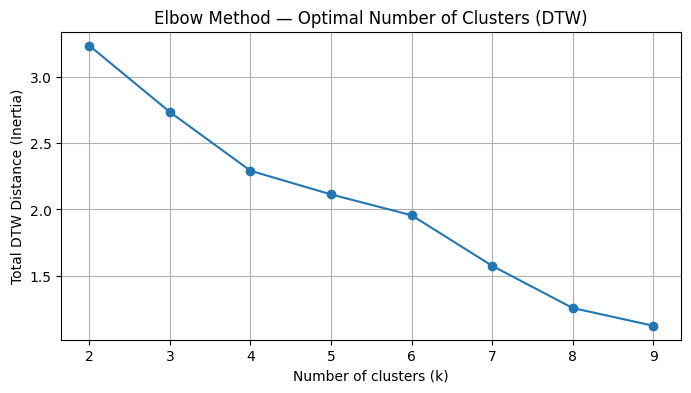

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set a range of k to try
k_range = range(2, 10)
inertia = []

# Step 0: Calculate monthly log growth rate per business (Needed to define data_growth)
# Ensure no zero values before taking logs
df_merged['value'] = df_merged['value'].replace(0, np.nan)
df_merged['sales_growth'] = df_merged.groupby('kind_of_business')['value'].transform(lambda x: np.log(x).diff())

# Step 1: Drop rows with missing growth rates (Needed to define data_growth)
df_growth_cleaned = df_merged.dropna(subset=['sales_growth']).copy()

# Step 2: Pivot table to shape (Date × Business) (Needed to define data_growth)
df_growth = df_growth_cleaned.groupby(['Date', 'kind_of_business'])['sales_growth'].mean().reset_index()
df_growth_matrix = df_growth.pivot(index='Date', columns='kind_of_business', values='sales_growth')

# Step 3: Transpose to (Businesses × Time) (Needed to define data_growth)
data_growth = df_growth_matrix.T.fillna(0).values  # shape: (n_businesses, n_timepoints)


# Run clustering for each k
for k in k_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    model.fit(data_growth)
    inertia.append(model.inertia_)  # total within-cluster DTW distance

# Plot the elbow
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method — Optimal Number of Clusters (DTW)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total DTW Distance (Inertia)")
plt.grid(True)
plt.show()

**Exploratory Visualization of Time-Series Clusters**

This code visualizes the time-series sales patterns of retail businesses grouped by their DTW-based cluster assignments. First, it prints the number and names of business types in each cluster, offering interpretability into how categories are grouped. Then, for each cluster, it plots the standardized monthly sales (Z-scores) over time for all businesses in that cluster. These visualizations help uncover temporal similarities—such as seasonality, trend, or volatility—shared within each group, enabling a clearer understanding of how different retail sectors respond to economic cycles, structural shifts, or external shocks like COVID-19.

📊 Number of business types in each cluster (based on growth):
 cluster
0    20
1    17
2    24
3     4
Name: count, dtype: int64

📦 Cluster 0: 20 businesses
['All other home furnishings stores', 'Beer, wine, and liquor stores', 'Electronic shopping and mail-order houses', 'Fuel dealers', 'Furniture and home furnishings stores', 'Furniture, home furn, electronics, and appliance stores', 'Home furnishings stores', 'Household appliance stores', 'Miscellaneous store retailers', 'Nonstore retailers', 'Other clothing stores', 'Other general merchandise stores', 'Retail and food services sales, total', 'Retail sales and food services excl gasoline stations', 'Retail sales and food services excl motor vehicle and parts', 'Retail sales and food services excl motor vehicle and parts and gasoline stations', 'Retail sales, total', 'Retail sales, total (excl. motor vehicle and parts dealers)', 'Used merchandise stores', 'Warehouse clubs and superstores']


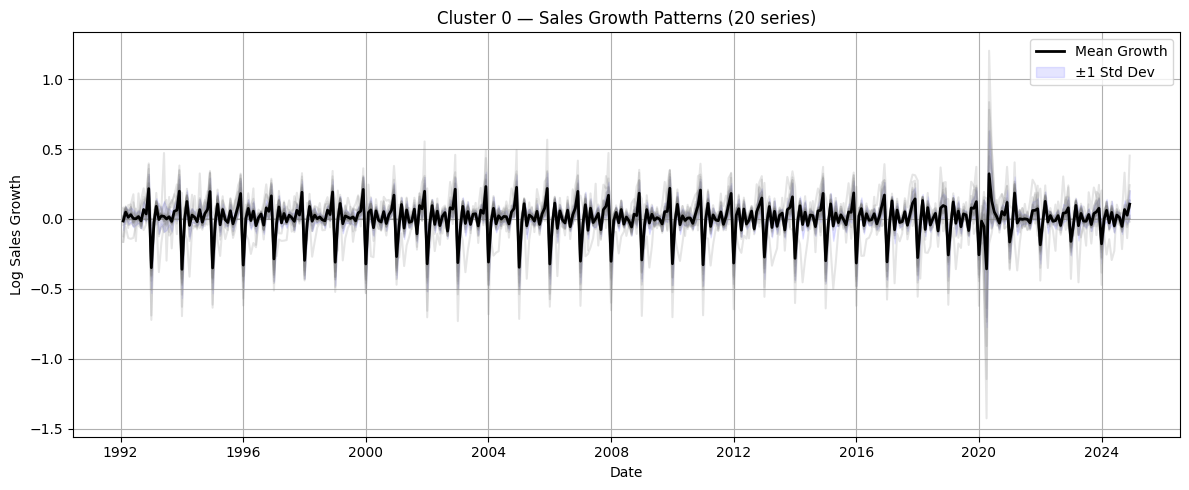


📦 Cluster 1: 17 businesses
['All other gen. merchandise stores', 'Book stores', 'Clothing and clothing access. stores', 'Clothing stores', 'Department stores', 'Discount dept. stores', 'Electronics and appliance stores', 'Electronics stores', 'Family clothing stores', 'GAFO(1)', 'General merchandise stores', "Men's clothing stores", 'Office supplies, stationery, and gift stores', 'Shoe stores', 'Sporting goods stores', 'Sporting goods, hobby, musical instrument, and book stores', "Women's clothing stores"]


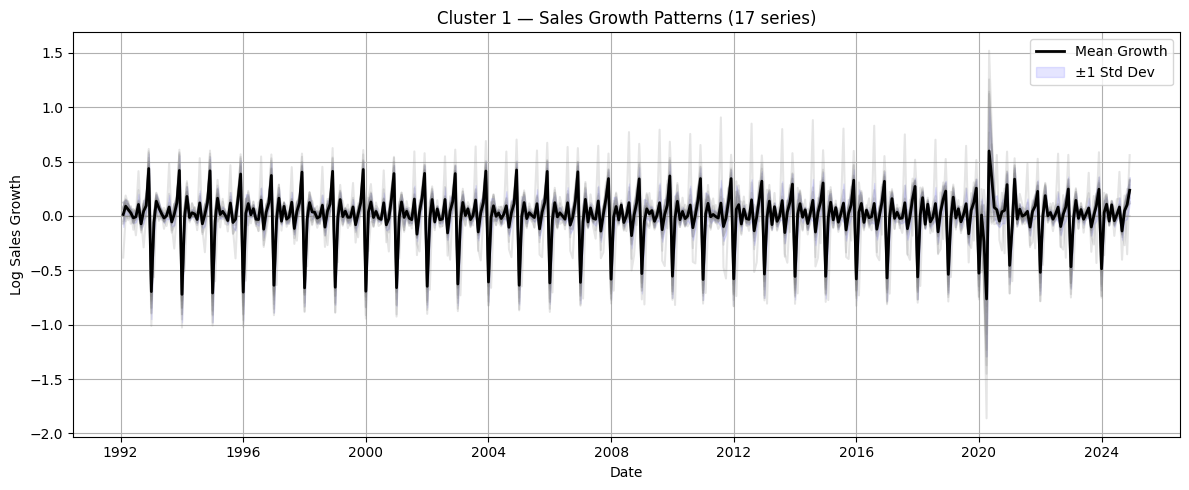


📦 Cluster 2: 24 businesses
['Automobile and other motor vehicle dealers', 'Automobile dealers', 'Automotive parts, acc., and tire stores', 'Building mat. and garden equip. and supplies dealers', 'Building mat. and supplies dealers', 'Drinking places', 'Floor covering stores', 'Food and beverage stores', 'Food services and drinking places', 'Full service restaurants', 'Furniture stores', 'Gasoline stations', 'Grocery stores', 'Hardware stores', 'Health and personal care stores', 'Limited service eating places', 'Motor vehicle and parts dealers', 'New car dealers', 'Office supplies and stationery stores', 'Paint and wallpaper stores', 'Pharmacies and drug stores', 'Restaurants and other eating places', 'Supermarkets and other grocery (except convenience) stores', 'Used car dealers']


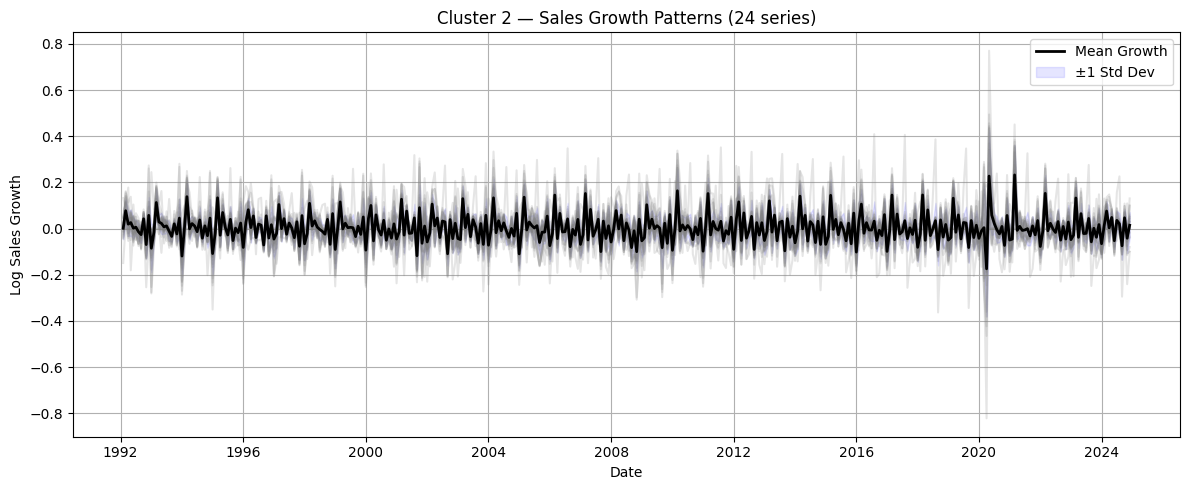


📦 Cluster 3: 4 businesses
['Department stores(excl. discount department stores)', 'Gift, novelty, and souvenir stores', 'Hobby, toy, and game stores', 'Jewelry stores']


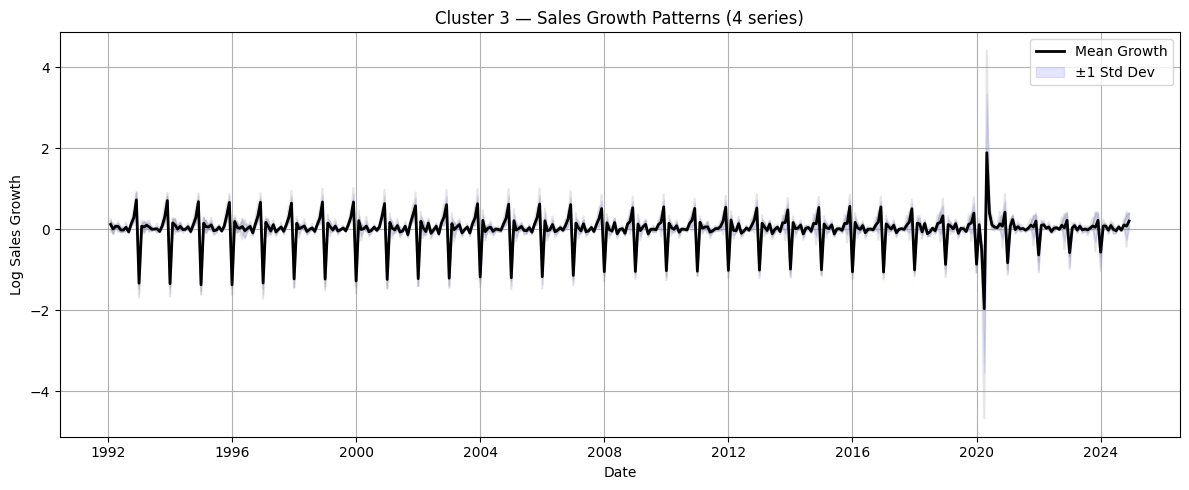

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

# Step 0: Calculate monthly log growth rate per business
df_merged = df_merged.copy()
df_merged['value'] = df_merged['value'].replace(0, np.nan)
df_merged['sales_growth'] = df_merged.groupby('kind_of_business')['value'].transform(
    lambda x: np.log(x).diff()
)

# Step 1: Drop rows with missing growth rates
df_growth_cleaned = df_merged.dropna(subset=['sales_growth'])

# Step 2: Pivot table to shape (Date × Business)
df_growth = df_growth_cleaned.groupby(['Date', 'kind_of_business'])['sales_growth'].mean().reset_index()
df_growth_matrix = df_growth.pivot(index='Date', columns='kind_of_business', values='sales_growth')

# Step 3: Transpose to (Businesses × Time)
data_growth = df_growth_matrix.T.fillna(0).values  # shape: (n_businesses, n_timepoints)

# Step 4: DTW-based clustering on growth rate series
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=42)
labels = model.fit_predict(data_growth)

# Step 5: Assign labels to business names
business_names = df_growth_matrix.columns.tolist()
df_cluster_labels = pd.DataFrame({
    'kind_of_business': business_names,
    'cluster': labels
})

# Step 6: Count businesses per cluster
cluster_counts = df_cluster_labels['cluster'].value_counts().sort_index()
print("📊 Number of business types in each cluster (based on growth):\n", cluster_counts)

# Step 7: Plot clusters (growth patterns)
for c in sorted(df_cluster_labels['cluster'].unique()):
    businesses_in_cluster = df_cluster_labels[df_cluster_labels['cluster'] == c]['kind_of_business']

    print(f"\n📦 Cluster {c}: {len(businesses_in_cluster)} businesses")
    print(sorted(businesses_in_cluster.tolist()))

    # Extract and stack time series for this cluster
    cluster_data = df_growth_matrix[businesses_in_cluster].fillna(0)
    cluster_array = cluster_data.values.T  # shape: (n_businesses, n_timepoints)

    # Compute mean and std over time
    cluster_mean = cluster_array.mean(axis=0)
    cluster_std = cluster_array.std(axis=0)

    # Plot all series + mean
    plt.figure(figsize=(12, 5))
    for series in cluster_array:
        plt.plot(df_growth_matrix.index, series, color='gray', alpha=0.2)

    plt.plot(df_growth_matrix.index, cluster_mean, color='black', label='Mean Growth', linewidth=2)
    plt.fill_between(df_growth_matrix.index, cluster_mean - cluster_std, cluster_mean + cluster_std,
                     color='blue', alpha=0.1, label='±1 Std Dev')

    plt.title(f"Cluster {c} — Sales Growth Patterns ({len(businesses_in_cluster)} series)")
    plt.xlabel("Date")
    plt.ylabel("Log Sales Growth")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**GDP-Based Regime Detection Using Markov Switching Model**

This code applies a two-regime Markov Switching model to smoothed monthly U.S. GDP growth to identify periods of economic expansion and recession. It plots the smoothed GDP growth alongside the estimated probability of being in a recession (Regime 1) over time.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


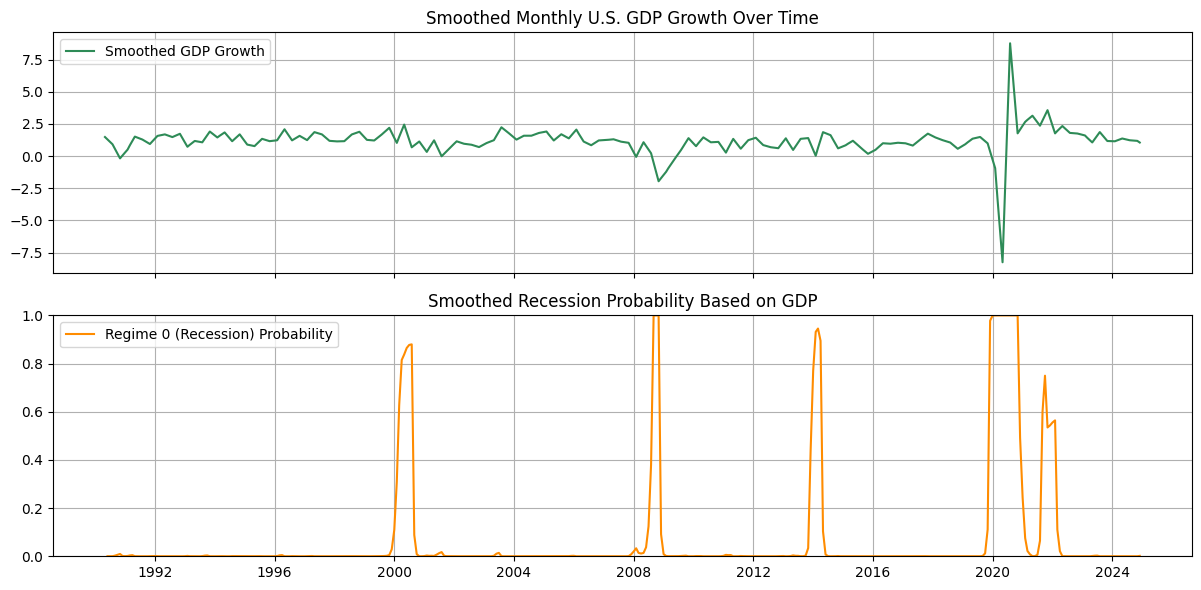

                         Markov Switching Model Results                         
Dep. Variable:      gdp_growth_smoothed   No. Observations:                  415
Model:             MarkovAutoregression   Log Likelihood                   6.721
Date:                  Thu, 31 Jul 2025   AIC                              2.558
Time:                          01:23:40   BIC                             34.784
Sample:                               0   HQIC                            15.301
                                  - 415                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9151      0.204      4.493      0.000       0.516       1.314
sigma2         4.0799      1.631    

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Step 0: Smooth GDP growth using a 3-month moving average
df_macro['gdp_growth_smoothed'] = df_macro['gdp_growth_m'].rolling(window=3, center=True).mean()
df_macro_smoothed = df_macro.dropna(subset=['gdp_growth_smoothed']).copy()

# Step 1: Fit Markov Switching model
mod_gdp = sm.tsa.MarkovAutoregression(df_macro_smoothed['gdp_growth_smoothed'],
                                       k_regimes=2, order=1, trend='c', switching_variance=True)
res_gdp = mod_gdp.fit()

# Step 2: Determine which regime is recession (lower mean)
# Inspect the parameter names to find the correct ones for the means
# print(res_gdp.params.index) # Uncomment this line to see the available parameter names

# Assuming the parameters for the mean are named 'const[0]' and 'const[1]' based on trend='c'
# If this doesn't work, uncomment the line above and check the output for the correct names
mean_regime_0 = res_gdp.params['const[0]']
mean_regime_1 = res_gdp.params['const[1]']


if mean_regime_1 < mean_regime_0:
    df_macro_smoothed['prob_recession_gdp'] = res_gdp.smoothed_marginal_probabilities[1]
    recession_label = 'Regime 1 (Recession)'
else:
    df_macro_smoothed['prob_recession_gdp'] = res_gdp.smoothed_marginal_probabilities[0]
    recession_label = 'Regime 0 (Recession)'

df_macro_smoothed['Date'] = pd.to_datetime(df_macro_smoothed['Date'])

# Step 3: Plot GDP growth + corrected regime probabilities
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top: GDP Growth
axes[0].plot(df_macro_smoothed['Date'], df_macro_smoothed['gdp_growth_smoothed'],
             label="Smoothed GDP Growth", color='seagreen')
axes[0].set_title("Smoothed Monthly U.S. GDP Growth Over Time")
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Bottom: Smoothed probability of RECESSION (automatically identified)
axes[1].plot(df_macro_smoothed['Date'], df_macro_smoothed['prob_recession_gdp'],
             label=f"{recession_label} Probability", color='darkorange')
axes[1].set_title("Smoothed Recession Probability Based on GDP")
axes[1].set_ylim(0, 1)
axes[1].legend(loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print regime summary
print(res_gdp.summary())




In [ ]:
pip install ruptures


**Baseline Model: Ordinary Least Squares (OLS)**
In this phase, we use Ordinary Least Squares (OLS) regression as a baseline model to estimate the relationship between macroeconomic indicators and retail sales growth for each cluster over the full 1992–2024 period. As a standard linear model without regularization, OLS serves as a foundational benchmark that reflects the direct effect of input features on sales growth without any penalty on coefficient magnitude. This simple yet interpretable model allows us to capture the core macro-retail dynamics and provides a reference point for identifying structural deviations in later analyses. The residuals from the OLS model are subsequently used in structural change detection algorithms to uncover significant shifts in the underlying economic relationships.


📊 Cluster 0 — Comparison (1992–2024)
➡️ RidgeCV | Best alpha: 1.1514, MSE: 0.0169, R²: 0.1397
➡️ OLS     | MSE: 0.0169, R²: 0.1403


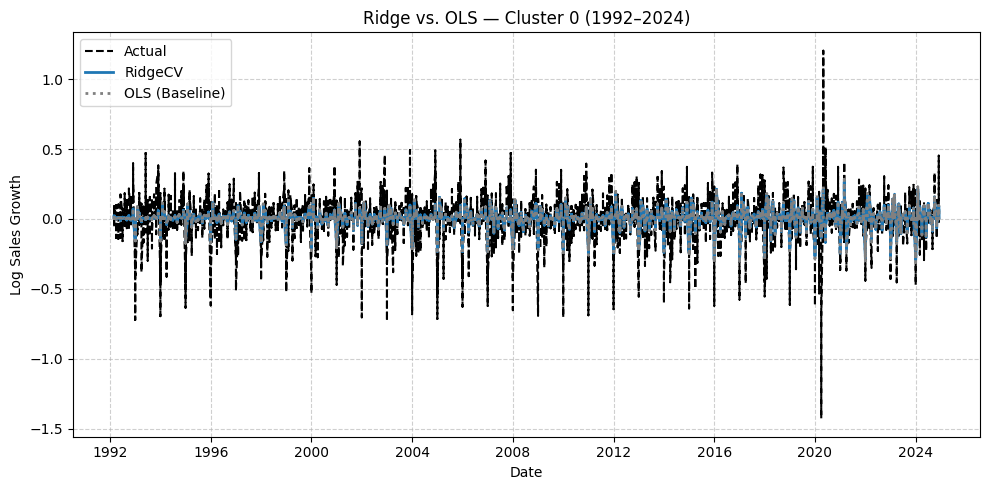


📊 Cluster 1 — Comparison (1992–2024)
➡️ RidgeCV | Best alpha: 0.6551, MSE: 0.0508, R²: 0.1910
➡️ OLS     | MSE: 0.0508, R²: 0.1910


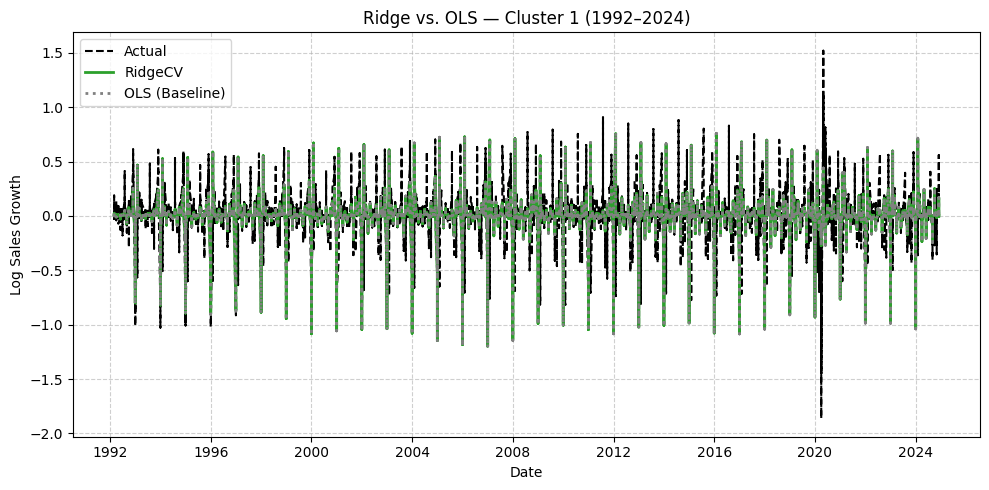


📊 Cluster 2 — Comparison (1992–2024)
➡️ RidgeCV | Best alpha: 1.5264, MSE: 0.0051, R²: 0.2806
➡️ OLS     | MSE: 0.0051, R²: 0.2823


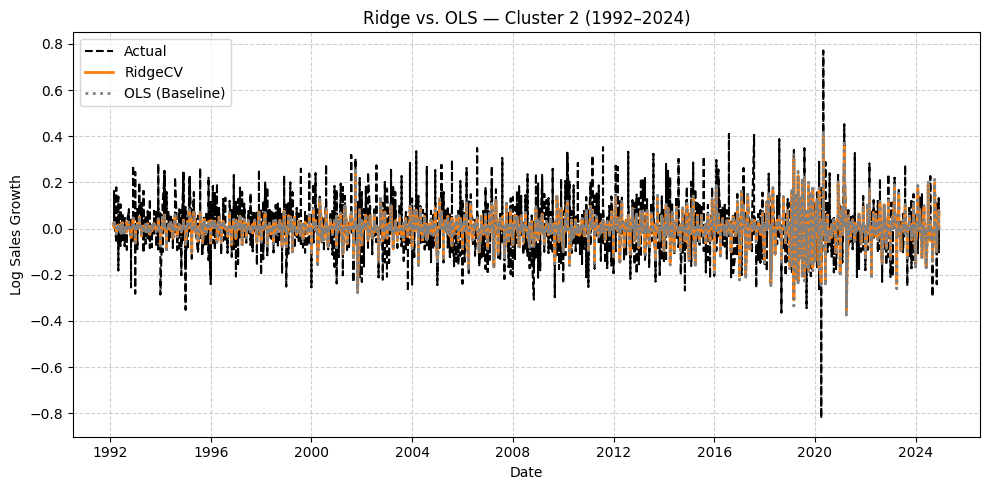

In [ ]:
from sklearn.linear_model import RidgeCV, LinearRegression  # Add LinearRegression

# ... [rest of your code above remains unchanged]

# Loop through clusters
for c in sorted(df_merged['cluster'].dropna().unique()):
    df_cluster = df_merged[df_merged['cluster'] == c].dropna(subset=features + [target, 'Date'])
    df_cluster = df_cluster.sort_values('Date').reset_index(drop=True)

    if df_cluster.empty:
        print(f"⚠️ Cluster {c}: no data, skipping.")
        continue

    # Extract X and y
    X = df_cluster[features].values
    y = df_cluster[target].values
    dates = pd.to_datetime(df_cluster['Date'])

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # === RidgeCV Model ===
    ridge_model = RidgeCV(alphas=alphas, cv=5)
    ridge_model.fit(X_scaled, y)
    y_pred_ridge = ridge_model.predict(X_scaled)
    mse_ridge = mean_squared_error(y, y_pred_ridge)
    r2_ridge = r2_score(y, y_pred_ridge)

    # === OLS Model (Baseline) ===
    ols_model = LinearRegression()
    ols_model.fit(X_scaled, y)
    y_pred_ols = ols_model.predict(X_scaled)
    mse_ols = mean_squared_error(y, y_pred_ols)
    r2_ols = r2_score(y, y_pred_ols)

    # === Print Evaluation ===
    print(f"\n📊 Cluster {c} — Comparison (1992–2024)")
    print(f"➡️ RidgeCV | Best alpha: {ridge_model.alpha_:.4f}, MSE: {mse_ridge:.4f}, R²: {r2_ridge:.4f}")
    print(f"➡️ OLS     | MSE: {mse_ols:.4f}, R²: {r2_ols:.4f}")

    # === Plot Comparison ===
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y, label="Actual", linestyle='--', color='black', linewidth=1.5)
    plt.plot(dates, y_pred_ridge, label="RidgeCV", color=cluster_colors.get(c, '#1f77b4'), linewidth=2)
    plt.plot(dates, y_pred_ols, label="OLS (Baseline)", color='gray', linestyle=':', linewidth=2)

    plt.title(f"Ridge vs. OLS — Cluster {c} (1992–2024)")
    plt.xlabel("Date")
    plt.ylabel("Log Sales Growth")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"ridge_vs_ols_cluster_{c}.png", dpi=300)
    plt.show()


**Structural Change Detection Using PELT and Binary Segmentation**
In this phase, we apply change-point detection algorithms—specifically PELT and Binary Segmentation from the ruptures library—to the residuals of our baseline model, which is an Ordinary Least Squares (OLS) regression fitted on the full 1992–2024 dataset. By analyzing the residuals (i.e., the portion of sales growth not explained by the model), we aim to identify structural breakpoints where the relationship between macroeconomic indicators and retail sales undergoes significant change. These breakpoints often correspond to major economic events—such as the onset of COVID-19 or inflationary shocks—highlighting moments when macro-retail dynamics shift in fundamental ways. Detecting such changes in the baseline model is crucial: it provides a reference point for evaluating the stability of the sales-growth generating process and informs whether more sophisticated models (e.g., regularized regressions or regime-switching frameworks) are needed to better capture the evolving economic environment.


🔎 Processing Cluster 0


/tmp/ipython-input-3958430244.py:69: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


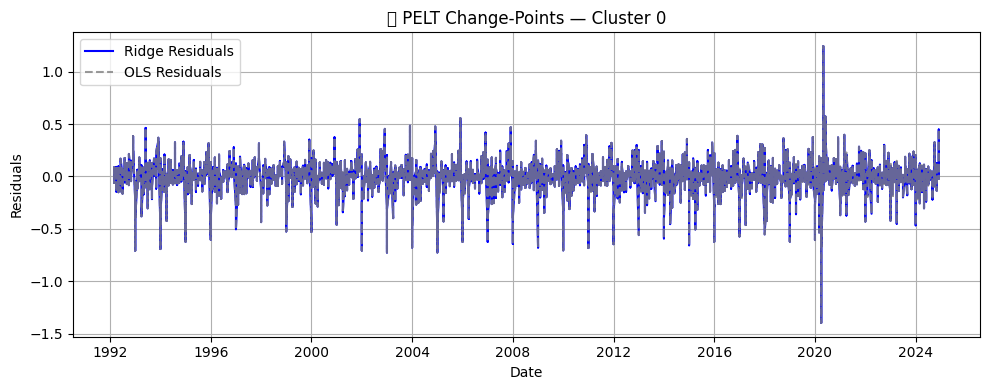

📌 Cluster 0 — Structural Change Evaluation
▪️ Number of Breakpoints: 0
▪️ Break Dates: []
▪️ Total Variance (Ridge Residuals): 0.0169
▪️ Total Variance (OLS Residuals): 0.0169
▪️ Segmented Cost (Lower is Better): 128.01

🔎 Processing Cluster 1


/tmp/ipython-input-3958430244.py:69: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


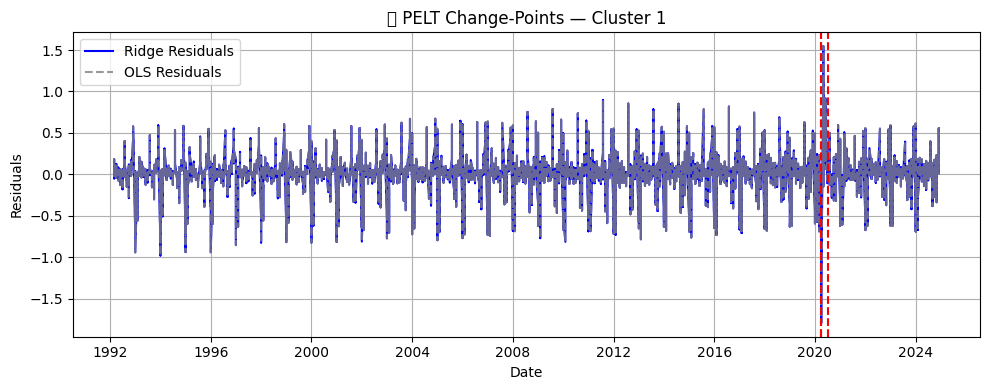

📌 Cluster 1 — Structural Change Evaluation
▪️ Number of Breakpoints: 3
▪️ Break Dates: ['2020-04-01', '2020-04-01', '2020-07-01']
▪️ Total Variance (Ridge Residuals): 0.0508
▪️ Total Variance (OLS Residuals): 0.0508
▪️ Segmented Cost (Lower is Better): 319.34

🔎 Processing Cluster 2


/tmp/ipython-input-3958430244.py:69: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


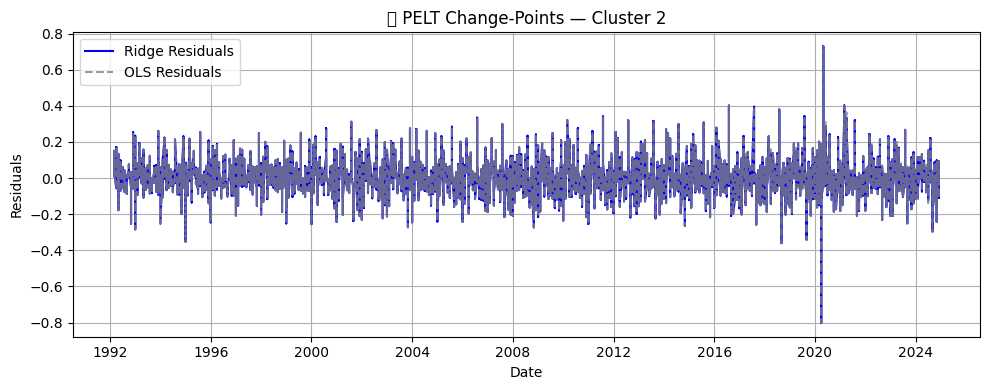

📌 Cluster 2 — Structural Change Evaluation
▪️ Number of Breakpoints: 0
▪️ Break Dates: []
▪️ Total Variance (Ridge Residuals): 0.0051
▪️ Total Variance (OLS Residuals): 0.0051
▪️ Segmented Cost (Lower is Better): 45.72


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Cluster-specific best alpha values from RidgeCV
best_alphas = {
    0: 1.1514,
    1: 0.6551,
    2: 1.5264
}

# Features and target
features = ['Inflation', 'gdp_growth_m', 'sales_lag1', 'sales_rolling_mean', 'regime']
target = 'sales_growth'

for c in sorted(df_merged['cluster'].dropna().unique()):
    print(f"\n🔎 Processing Cluster {c}")

    df_cluster = df_merged[df_merged['cluster'] == c].dropna(subset=features + [target, 'Date'])
    df_cluster = df_cluster.sort_values('Date').reset_index(drop=True)

    if len(df_cluster) < 100:
        print(f"⚠️ Skipping Cluster {c} — not enough data for change-point detection")
        continue

    # Extract X, y, dates
    X = df_cluster[features].values
    y = df_cluster[target].values
    dates = df_cluster['Date'].values

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- OLS Baseline ---
    ols_model = LinearRegression()
    ols_model.fit(X_scaled, y)
    y_pred_ols = ols_model.predict(X_scaled)
    residuals_ols = y - y_pred_ols

    # --- Ridge Model ---
    alpha = best_alphas.get(c, 1.0)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_scaled, y)
    y_pred_ridge = ridge_model.predict(X_scaled)
    residuals_ridge = y - y_pred_ridge

    # --- PELT on Ridge residuals ---
    signal = residuals_ridge.reshape(-1, 1)
    pelt_model = rpt.Pelt(model="l2").fit(signal)
    pelt_bkps = pelt_model.predict(pen=3)

    # --- Plot residuals + change points ---
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(dates, residuals_ridge, label="Ridge Residuals", color='blue')
    ax.plot(dates, residuals_ols, label="OLS Residuals", color='gray', linestyle='--', alpha=0.8)
    for bkp in pelt_bkps:
        if bkp < len(dates):
            ax.axvline(dates[bkp], color='red', linestyle='--', lw=1.5)
    ax.set_title(f"📍 PELT Change-Points — Cluster {c}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Residuals")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Evaluation Metrics ---
    break_dates = df_cluster['Date'].iloc[pelt_bkps[:-1]].values
    n_breaks = len(break_dates)
    total_var_ridge = np.var(residuals_ridge)
    total_var_ols = np.var(residuals_ols)
    segmented_cost = pelt_model.cost.sum_of_costs(pelt_bkps)

    print(f"📌 Cluster {c} — Structural Change Evaluation")
    print(f"▪️ Number of Breakpoints: {n_breaks}")
    print(f"▪️ Break Dates: {[str(pd.to_datetime(d).date()) for d in break_dates]}")
    print(f"▪️ Total Variance (Ridge Residuals): {total_var_ridge:.4f}")
    print(f"▪️ Total Variance (OLS Residuals): {total_var_ols:.4f}")
    print(f"▪️ Segmented Cost (Lower is Better): {segmented_cost:.2f}")



**Ridge Regression Model with Regime, Macro, and Lag Features (Pre-COVID Only)**
In this model, we estimate a separate Ridge regression for each retail cluster using pre-COVID data, incorporating macroeconomic, lagged, and regime-based features. The target variable is the log-differenced sales growth (sales_growth), used in its original form across all clusters. The feature set includes inflation, monthly GDP growth, lagged sales (sales_lag1, sales_rolling_mean), and a regime indicator derived from a Markov Switching model on total retail sales. All features are standardized using z-scores. Ridge regression is applied with a cluster-specific L2 penalty (α), optimized via cross-validation. Model performance is evaluated by plotting residuals over time and as histograms, and by reporting the Mean Squared Error (MSE) and R² for each cluster to assess fit and explanatory power.

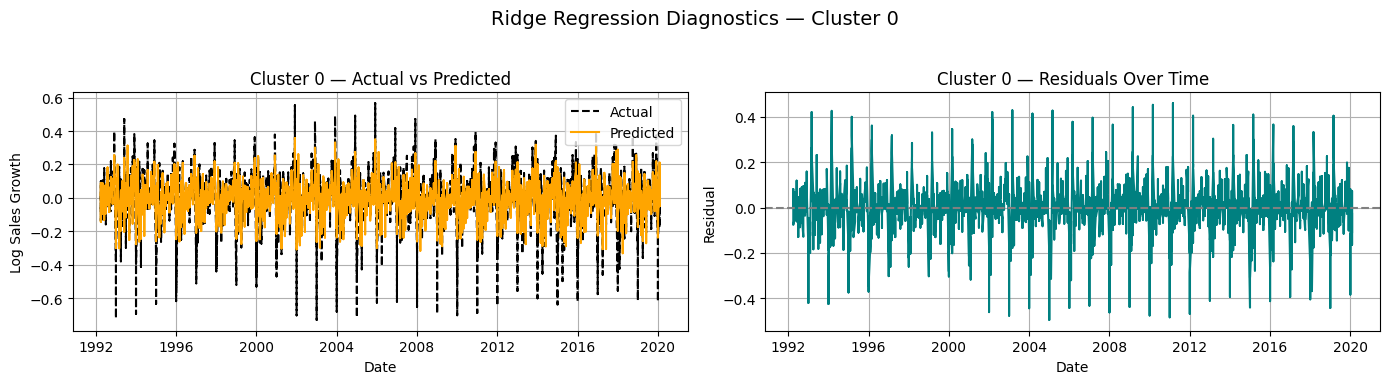

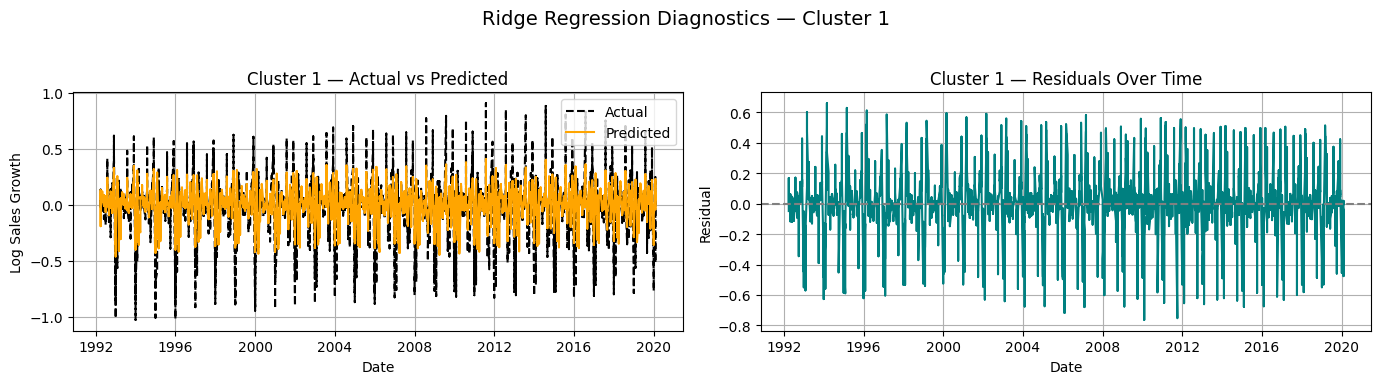

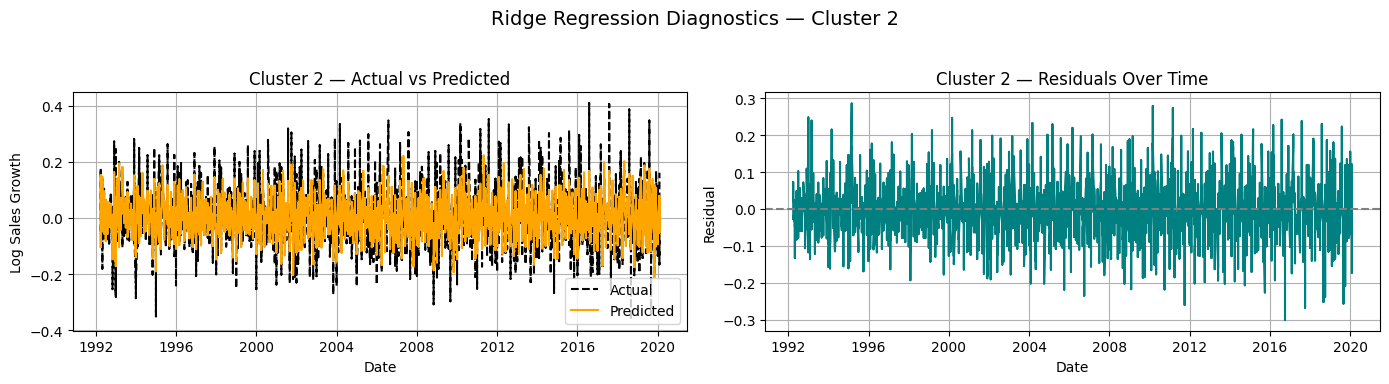


📋 Ridge Regression Results (Pre-COVID Only):
 Cluster  Sample Size   MSE    R²  Alpha
       0         6484 0.012 0.406 1.1514
       1         5635 0.039 0.362 0.6551
       2         7763 0.003 0.477 1.5264


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Settings
target = 'sales_growth'
covid_cutoff = pd.to_datetime("2020-03-01")
features = ['Inflation', 'gdp_growth_m', 'sales_lag1', 'sales_rolling_mean', 'regime']
alpha_dict = {0: 1.1514, 1: 0.6551, 2: 1.5264}

results = []

# Loop through clusters
for cluster_id in sorted(df_merged['cluster'].dropna().unique()):
    if cluster_id == 3:
        continue  # Skip cluster 3

    df_cluster = df_merged[df_merged['cluster'] == cluster_id].copy()
    df_cluster['Date'] = pd.to_datetime(df_cluster['Date'])
    df_cluster = df_cluster[df_cluster['Date'] < covid_cutoff].sort_values('Date')

    # Sales growth
    df_cluster['value'] = df_cluster['value'].replace(0, np.nan)
    df_cluster['sales_growth'] = df_cluster.groupby('kind_of_business')['value'].transform(lambda x: np.log(x).diff())

    # Lagged features (inside cluster)
    df_cluster['sales_lag1'] = df_cluster.groupby('kind_of_business')['sales_growth'].shift(1)
    df_cluster['sales_rolling_mean'] = df_cluster.groupby('kind_of_business')['sales_growth'].transform(
        lambda x: x.rolling(window=3).mean())

    df_cluster = df_cluster.dropna(subset=features + [target])

    if len(df_cluster) < 30:
        continue

    X = df_cluster[features].values
    y = df_cluster[target].values
    dates = df_cluster['Date']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    alpha_val = alpha_dict.get(cluster_id, 1.0)
    model = Ridge(alpha=alpha_val)
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    residuals = y - y_pred

    # Store results
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results.append({
        'Cluster': cluster_id,
        'Sample Size': len(df_cluster),
        'MSE': round(mse, 3),
        'R²': round(r2, 3),
        'Alpha': round(alpha_val, 4)
    })

    # === Plot: Left = Actual vs Predicted, Right = Residuals ===
    fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    # Actual vs Predicted
    axs[0].plot(dates, y, label="Actual", linestyle='--', color='black')
    axs[0].plot(dates, y_pred, label="Predicted", color='orange')
    axs[0].set_title(f"Cluster {cluster_id} — Actual vs Predicted")
    axs[0].set_ylabel("Log Sales Growth")
    axs[0].set_xlabel("Date")
    axs[0].grid(True)
    axs[0].legend()

    # Residuals
    axs[1].plot(dates, residuals, color='teal')
    axs[1].axhline(0, linestyle='--', color='gray')
    axs[1].set_title(f"Cluster {cluster_id} — Residuals Over Time")
    axs[1].set_ylabel("Residual")
    axs[1].set_xlabel("Date")
    axs[1].grid(True)

    # 📉 Removed emoji here to avoid font warning
    plt.suptitle(f"Ridge Regression Diagnostics — Cluster {cluster_id}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Final summary table
results_df = pd.DataFrame(results)
print("\n📋 Ridge Regression Results (Pre-COVID Only):")
print(results_df.to_string(index=False))


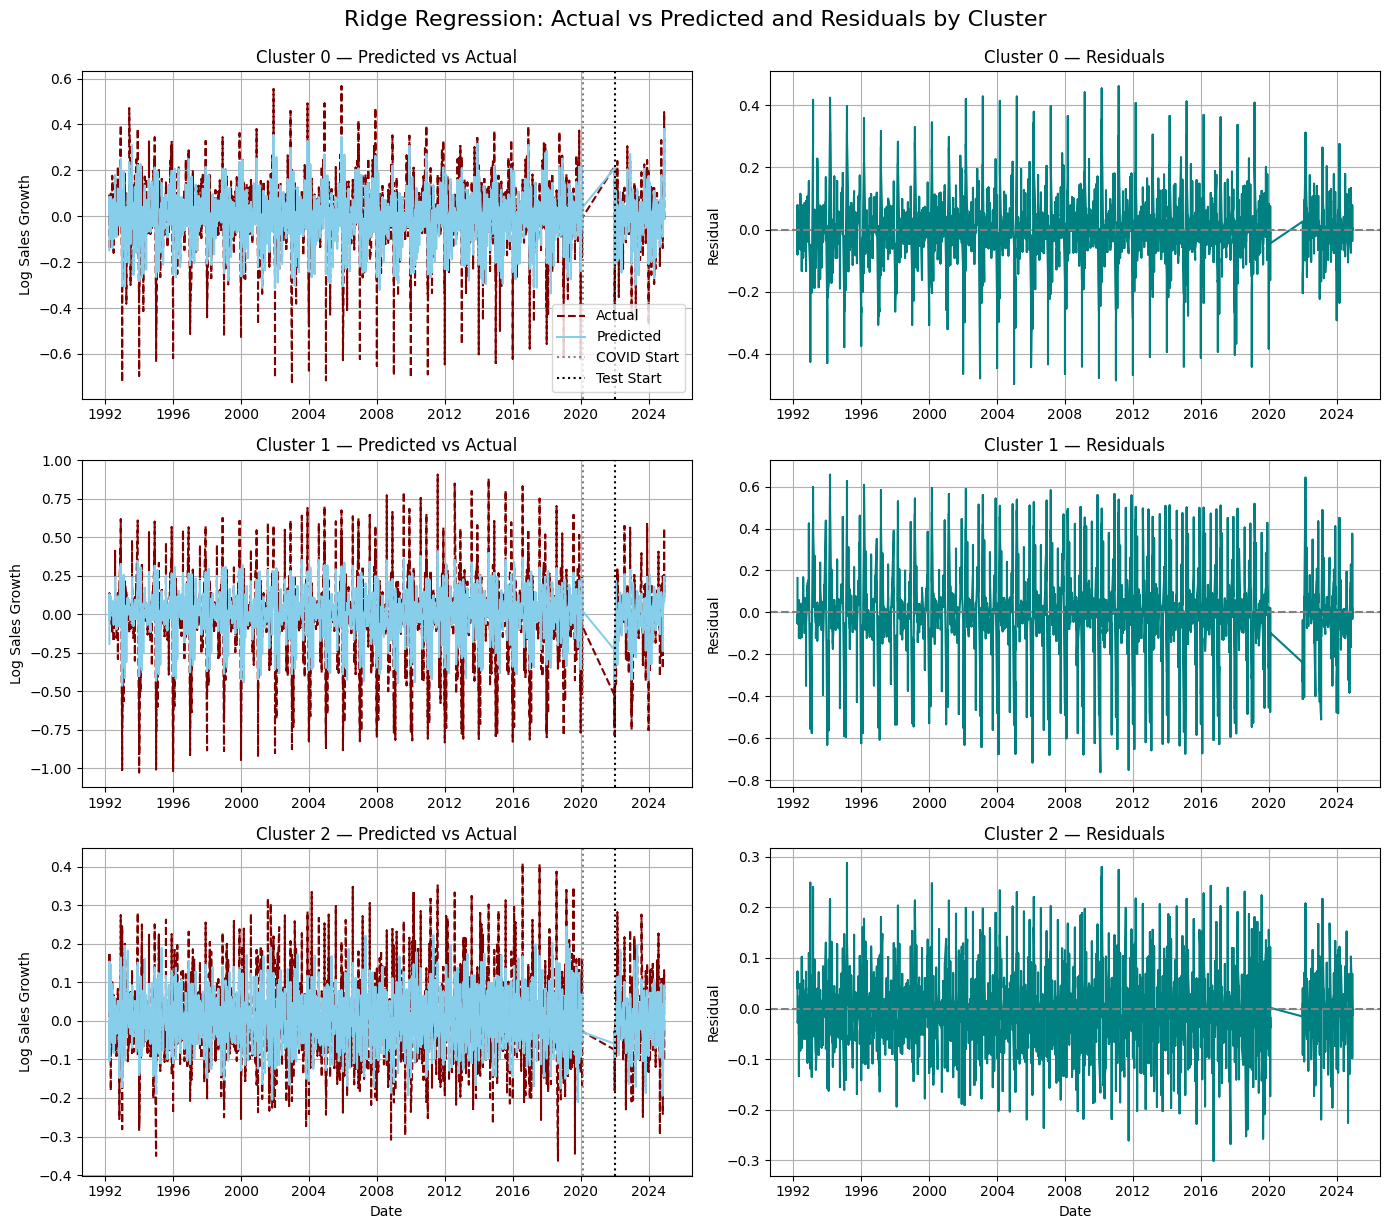


📋 Ridge Regression Results (Simplified Model):
 Cluster  Train Size  Test Size  Train MSE  Train R²  Test MSE  Test R²
       0        6484        648      0.012     0.406     0.006    0.407
       1        5635        576      0.039     0.362     0.028    0.321
       2        7763        756      0.003     0.477     0.003    0.490


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import detrend

# Settings
target = 'sales_growth'
train_cutoff = pd.to_datetime("2020-03-01")
test_start = pd.to_datetime("2022-01-01")
alpha_dict = {0: 2.68, 1: 1.53, 2: 4.71}
features = ['Inflation', 'gdp_growth_m', 'sales_lag1', 'sales_rolling_mean', 'regime']

results = []
fig, axes = plt.subplots(3, 2, figsize=(14, 12))  # 3 rows (clusters), 2 columns (prediction + residual)

for row_idx, cluster_id in enumerate(sorted(df_merged['cluster'].dropna().unique())):
    df_cluster = df_merged[df_merged['cluster'] == cluster_id].copy()
    df_cluster['Date'] = pd.to_datetime(df_cluster['Date'])
    df_cluster = df_cluster.sort_values('Date')

    # Feature Engineering
    df_cluster['sales_lag1'] = df_cluster.groupby('kind_of_business')['sales_growth'].shift(1)
    df_cluster['sales_rolling_mean'] = df_cluster.groupby('kind_of_business')['sales_growth'].transform(lambda x: x.rolling(3).mean())
    df_cluster = df_cluster.dropna(subset=features + [target])

    df_train = df_cluster[df_cluster['Date'] < train_cutoff]
    df_test = df_cluster[df_cluster['Date'] >= test_start]

    if len(df_train) < 50 or len(df_test) < 30:
        print(f"⚠️ Skipping Cluster {cluster_id}: not enough data.")
        continue

    X_train = df_train[features].values
    X_test = df_test[features].values
    y_train_raw = df_train[target].values
    y_test_raw = df_test[target].values

    # Detrend clusters 0 & 1
    y_train = detrend(y_train_raw) if cluster_id in [0, 1] else y_train_raw
    y_test = detrend(y_test_raw) if cluster_id in [0, 1] else y_test_raw

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    alpha_val = alpha_dict.get(cluster_id, 1.0)
    model = Ridge(alpha=alpha_val)
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Combine for plotting
    dates_combined = np.concatenate([df_train['Date'].values, df_test['Date'].values])
    actual_combined = np.concatenate([y_train_raw, y_test_raw])
    predicted_combined = np.concatenate([y_pred_train, y_pred_test])
    residuals_combined = np.concatenate([residuals_train, residuals_test])

    # Store results
    results.append({
        'Cluster': cluster_id,
        'Train Size': len(df_train),
        'Test Size': len(df_test),
        'Train MSE': round(mean_squared_error(y_train, y_pred_train), 3),
        'Train R²': round(r2_score(y_train, y_pred_train), 3),
        'Test MSE': round(mean_squared_error(y_test, y_pred_test), 3),
        'Test R²': round(r2_score(y_test, y_pred_test), 3)
    })

    # === Plot 1: Actual vs Predicted
    ax1 = axes[row_idx, 0]
    ax1.plot(dates_combined, actual_combined, label="Actual", linestyle='--', color='maroon')
    ax1.plot(dates_combined, predicted_combined, label="Predicted", color='skyblue')
    ax1.axvline(train_cutoff, linestyle=':', color='gray', label='COVID Start')
    ax1.axvline(test_start, linestyle=':', color='black', label='Test Start')
    ax1.set_title(f"Cluster {cluster_id} — Predicted vs Actual")
    ax1.set_ylabel("Log Sales Growth")
    ax1.grid(True)
    if row_idx == 2:
        ax1.set_xlabel("Date")
    if row_idx == 0:
        ax1.legend()

    # === Plot 2: Residuals
    ax2 = axes[row_idx, 1]
    ax2.plot(dates_combined, residuals_combined, label='Residuals', color='teal')
    ax2.axhline(0, linestyle='--', color='gray')
    ax2.set_title(f"Cluster {cluster_id} — Residuals")
    ax2.set_ylabel("Residual")
    ax2.grid(True)
    if row_idx == 2:
        ax2.set_xlabel("Date")

# === Final Touch
plt.tight_layout()
plt.suptitle("Ridge Regression: Actual vs Predicted and Residuals by Cluster", fontsize=16, y=1.02)
plt.show()

# Summary Table
results_df = pd.DataFrame(results)
print("\n📋 Ridge Regression Results (Simplified Model):")
print(results_df.to_string(index=False))

**Cross-Validated Ridge Regression Model (Out-of-Sample, Pre/Post-COVID)**
This model evaluates out-of-sample performance of Ridge regression by training on pre-COVID retail sales data (before March 2020) and testing on a post-COVID period beginning in January 2022, excluding the volatile pandemic period in between. Separate models are estimated for each cluster of retail businesses using a consistent set of standardized predictors, including inflation, monthly GDP growth, a regime indicator (from a Markov Switching model), and lagged sales metrics (sales_lag1, sales_rolling_mean).

Ridge regression is applied with alpha selected via 5-fold cross-validation from a log-spaced range of values. For each cluster, we report the cross-validated alpha, mean squared error (MSE), and R-squared (R²) on both training and test sets. We also extract the estimated coefficients to examine the relative importance of features across clusters. This approach helps identify how macroeconomic shocks and past sales dynamics influence future sales growth in different retail sectors under varying macro regimes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Time boundaries
train_cutoff = pd.to_datetime("2020-03-01")
test_start = pd.to_datetime("2022-01-01")
target = 'sales_growth'

results = []
all_coefs = []

# Define the alpha values to try in RidgeCV
alphas_to_try = np.logspace(-3, 2, 30)

# Define features
features = ['Inflation', 'gdp_growth_m', 'sales_lag1', 'sales_rolling_mean', 'regime']

# Loop over clusters
for cluster_id in sorted(df_merged['cluster'].dropna().unique()):
    df_cluster = df_merged[df_merged['cluster'] == cluster_id].copy()
    df_cluster['Date'] = pd.to_datetime(df_cluster['Date'])
    df_cluster = df_cluster.sort_values('Date')

    # Feature Engineering
    df_cluster['sales_lag1'] = df_cluster.groupby('kind_of_business')['sales_growth'].shift(1)
    df_cluster['sales_rolling_mean'] = df_cluster.groupby('kind_of_business')['sales_growth'].transform(
        lambda x: x.rolling(3).mean()
    )

    df_cluster = df_cluster.dropna(subset=features + [target])

    # Train-test split
    df_train = df_cluster[df_cluster['Date'] < train_cutoff]
    df_test = df_cluster[df_cluster['Date'] >= test_start]

    if len(df_train) < 50 or len(df_test) < 30:
        print(f"⚠️ Skipping Cluster {cluster_id}: not enough data.")
        continue

    # Prepare inputs
    X_train = df_train[features].values
    y_train = df_train[target].values
    X_test = df_test[features].values
    y_test = df_test[target].values

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge regression with cross-validation
    model = RidgeCV(alphas=alphas_to_try, store_cv_results=True)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Residuals
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # Performance metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    results.append({
        'Cluster': cluster_id,
        'Train Size': len(df_train),
        'Test Size': len(df_test),
        'Alpha (CV)': round(model.alpha_, 4),
        'Train MSE': round(mse_train, 3),
        'Train R²': round(r2_train, 3),
        'Test MSE': round(mse_test, 3),
        'Test R²': round(r2_test, 3)
    })

    # Store coefficients
    for f, coef in zip(features, model.coef_):
        all_coefs.append({
            'Cluster': cluster_id,
            'Feature': f,
            'Coefficient': round(coef, 4)
        })

# === Output Results ===
results_df = pd.DataFrame(results)
coef_df = pd.DataFrame(all_coefs)

print("\n📋 Ridge Regression Performance (with CV-selected alpha):")
print(results_df.to_string(index=False))

print("\n📈 Ridge Coefficients by Cluster:")
print(coef_df.to_string(index=False))



📋 Ridge Regression Performance (with CV-selected alpha):
 Cluster  Train Size  Test Size  Alpha (CV)  Train MSE  Train R²  Test MSE  Test R²
       0        6484        648      6.2102      0.012     0.406     0.006    0.423
       1        5635        576      6.2102      0.039     0.362     0.028    0.345
       2        7763        756      2.8072      0.003     0.477     0.003    0.490

📈 Ridge Coefficients by Cluster:
 Cluster            Feature  Coefficient
       0          Inflation      -0.0083
       0       gdp_growth_m       0.0064
       0         sales_lag1      -0.0697
       0 sales_rolling_mean       0.0902
       0             regime      -0.0015
       1          Inflation      -0.0187
       1       gdp_growth_m       0.0138
       1         sales_lag1      -0.1242
       1 sales_rolling_mean       0.1358
       1             regime      -0.0013
       2          Inflation       0.0000
       2       gdp_growth_m      -0.0024
       2         sales_lag1      -0.040

In [ ]:
import os

print(os.listdir('/content/'))

['.config', 'retail_salse_long 2024.csv', 'monthly_macro_data.xlsx', 'sample_data']


In [ ]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00
